#Explicación del código: CNN + Algoritmo Genético (GA)

Este código implementa una Red Neuronal Convolucional (CNN) cuyo ajuste de pesos no se realiza con retropropagación, sino mediante un algoritmo genético (GA).
El objetivo es mostrar cómo las técnicas de optimización evolutiva pueden reemplazar o complementar el entrenamiento tradicional en redes neuronales.

#Funcionamiento general

- Carga un dataset de benchmarking (MNIST, Fashion-MNIST o CIFAR-10).

- Construye una CNN configurable, con capas convolucionales, pooling, dropout y capas densas.

- Convierte los pesos de la red en un vector que representa el “genoma” de cada individuo.

- Crea una población inicial de soluciones (diferentes configuraciones de pesos).

- Evalúa cada individuo según su exactitud en un subconjunto de validación (fitness).

- Aplica operadores genéticos:

  - Selección por torneo para elegir los mejores padres.

  - Cruce de un punto para combinar sus genes.

  - Mutación gaussiana para introducir variación aleatoria.

- Evoluciona durante varias generaciones, guardando los mejores individuos.

- Evalúa el mejor resultado en el conjunto de prueba (test set) al finalizar.

De esta forma, el algoritmo genético busca de manera iterativa los pesos que producen la mejor precisión posible, sin necesidad de calcular gradientes.

[INFO] Capas a evolucionar: [0, 2, 7, 8] | Genes totales: 1625866
[GEN 01] best=0.1621 | mean=0.1033
[GEN 02] best=0.1641 | mean=0.1109
[GEN 03] best=0.1797 | mean=0.1217
[GEN 04] best=0.1729 | mean=0.1107
[GEN 05] best=0.1895 | mean=0.1379
[GEN 06] best=0.2451 | mean=0.1493
[GEN 07] best=0.2295 | mean=0.1675
[GEN 08] best=0.2471 | mean=0.1909
[GEN 09] best=0.2568 | mean=0.2100
[GEN 10] best=0.2803 | mean=0.2168

[RESULTADO] Accuracy de TEST con el mejor GA: 0.2830


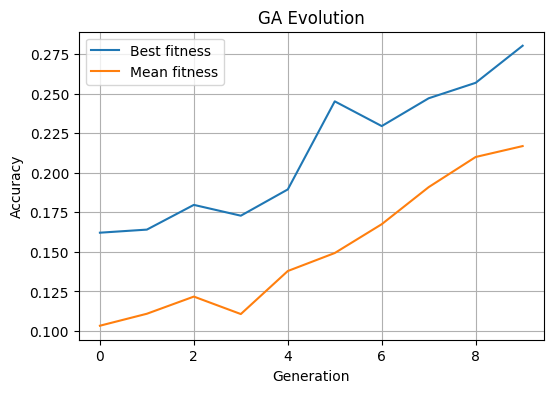

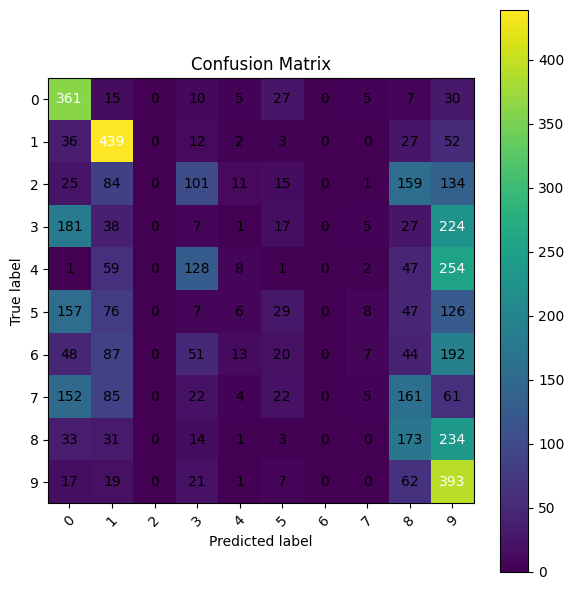


=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.3571    0.7848    0.4908       460
           1     0.4705    0.7688    0.5838       571
           2     0.0000    0.0000    0.0000       530
           3     0.0188    0.0140    0.0160       500
           4     0.1538    0.0160    0.0290       500
           5     0.2014    0.0636    0.0967       456
           6     0.0000    0.0000    0.0000       462
           7     0.1515    0.0098    0.0183       512
           8     0.2294    0.3538    0.2784       489
           9     0.2312    0.7558    0.3541       520

    accuracy                         0.2830      5000
   macro avg     0.1814    0.2767    0.1867      5000
weighted avg     0.1842    0.2830    0.1911      5000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:

# =========================================================
# CNN + Algoritmo Genético (GA) para AJUSTE DE PESOS
# + Gráficas de evolución (best/mean) y Matriz de Confusión
# =========================================================

import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# CONFIGURACIÓN AJUSTABLE
# ----------------------------
CONFIG = {
    # Dataset: 'mnist', 'fashion_mnist', 'cifar10'
    "dataset": "mnist",

    # Tamaños de subconjuntos para acelerar (puedes subirlos)
    "train_subset": 10000,  # usa <= tamaño real del dataset
    "val_subset":   2000,
    "test_subset":  5000,

    # Arquitectura CNN (simple para viabilidad con GA)
    "cnn": {
        "input_shape": None,   # se infiere según dataset
        "conv_blocks": [
            # Cada bloque: (filters, kernel_size, activation)
            (32, 3, "relu"),
            (64, 3, "relu")
        ],
        "use_batchnorm": False,
        "pool_after": True,     # MaxPool2D(2) tras el último conv
        "dropout": 0.25,        # 0.0 para desactivar
        "dense_units": 128,
        "dense_activation": "relu",
        "num_classes": None     # se infiere según dataset
    },

    # GA (Neuroevolución de pesos)
    "ga": {
        "population_size": 20,
        "generations": 10,
        "elitism": 2,               # nº de mejores que pasan directo
        "tournament_k": 3,          # selección por torneo
        "crossover_rate": 0.9,      # prob. de aplicar cruce
        "mutation_rate": 0.15,      # prob. de mutar cada gen (peso)
        "mutation_sigma": 0.02,     # desviación estándar de la mutación
        "weight_clip": 1.0,         # limita pesos a [-clip, clip] (None para desactivar)
        "evaluate_batches": 4,      # cuántos batches acumular para fitness (promedio)
        "batch_size": 256,
        "layers_to_evolve": "all",  # "all" o lista de índices Keras (ej. [ -1 ] para solo la última capa)
        "seed": 42
    }
}

# -----------------------------------------------------------
# Utilidades: carga de datos y preprocesamiento
# -----------------------------------------------------------
def load_dataset(name):
    if name == "mnist":
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        x_train = x_train[..., None]  # (28,28,1)
        x_test  = x_test[..., None]
        num_classes = 10
        input_shape = (28, 28, 1)
        class_names = [str(i) for i in range(10)]
    elif name == "fashion_mnist":
        (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
        x_train = x_train[..., None]  # (28,28,1)
        x_test  = x_test[..., None]
        num_classes = 10
        input_shape = (28, 28, 1)
        class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
                       "Sandal","Shirt","Sneaker","Bag","Ankle boot"]
    elif name == "cifar10":
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        y_train = y_train.flatten()
        y_test  = y_test.flatten()
        num_classes = 10
        input_shape = (32, 32, 3)
        class_names = ["airplane","automobile","bird","cat","deer",
                       "dog","frog","horse","ship","truck"]
    else:
        raise ValueError("Dataset no soportado.")

    # Normalización 0..1
    x_train = x_train.astype("float32") / 255.0
    x_test  = x_test.astype("float32") / 255.0

    return (x_train, y_train), (x_test, y_test), num_classes, input_shape, class_names

# -----------------------------------------------------------
# Construcción de la CNN (sin compilar con optimizador)
# -----------------------------------------------------------
def build_cnn(cfg_cnn):
    model = keras.Sequential()
    model.add(layers.Input(shape=cfg_cnn["input_shape"]))

    for i, (filters, k, act) in enumerate(cfg_cnn["conv_blocks"]):
        model.add(layers.Conv2D(filters, k, padding="same"))
        if cfg_cnn["use_batchnorm"]:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(act))

    if cfg_cnn["pool_after"]:
        model.add(layers.MaxPooling2D(2))

    if cfg_cnn["dropout"] and cfg_cnn["dropout"] > 0:
        model.add(layers.Dropout(cfg_cnn["dropout"]))

    model.add(layers.Flatten())
    model.add(layers.Dense(cfg_cnn["dense_units"], activation=cfg_cnn["dense_activation"]))
    model.add(layers.Dense(cfg_cnn["num_classes"], activation="softmax"))
    return model

# -----------------------------------------------------------
# Flatten/Rebuild de pesos para GA
# -----------------------------------------------------------
def get_weight_shapes(model, layer_indices):
    shapes = []
    for li in layer_indices:
        for w in model.layers[li].get_weights():
            shapes.append(w.shape)
    return shapes

def flatten_weights(model, layer_indices):
    flat_list = []
    for li in layer_indices:
        for w in model.layers[li].get_weights():
            flat_list.append(w.flatten())
    if not flat_list:
        return np.array([], dtype=np.float32)
    return np.concatenate(flat_list).astype(np.float32)

def set_weights_from_flat(model, layer_indices, flat_vector, shapes_cache=None):
    # Reconstruye y asigna únicamente las capas evolutivas
    ptr = 0
    idx = 0
    for li in layer_indices:
        weights = model.layers[li].get_weights()
        new_weights = []
        for w in weights:
            shape = w.shape if shapes_cache is None else shapes_cache[idx]
            size = np.prod(shape)
            chunk = flat_vector[ptr:ptr+size].reshape(shape)
            new_weights.append(chunk.astype(np.float32))
            ptr += size
            idx += 1
        model.layers[li].set_weights(new_weights)

def clip_weights(model, layer_indices, clipval):
    if clipval is None:
        return
    for li in layer_indices:
        weights = model.layers[li].get_weights()
        weights = [np.clip(w, -clipval, clipval) for w in weights]
        model.layers[li].set_weights(weights)

# -----------------------------------------------------------
# GA: representación, evaluación, selección, cruce, mutación
# -----------------------------------------------------------
def evaluate_fitness(model, x_val, y_val, batch_size=256, evaluate_batches=4):
    """
    Fitness = accuracy promedio en 'evaluate_batches' minibatches
    (se usa subset para acelerar).
    """
    n = x_val.shape[0]
    bs = batch_size
    batches = min(evaluate_batches, int(np.ceil(n / bs)))
    idxs = np.random.choice(n, size=min(n, bs*batches), replace=False)
    xv = x_val[idxs]
    yv = y_val[idxs]

    # predicciones por lotes
    accs = []
    for i in range(0, xv.shape[0], bs):
        xb = xv[i:i+bs]
        yb = yv[i:i+bs]
        preds = model.predict(xb, verbose=0)
        yhat = np.argmax(preds, axis=1)
        acc = (yhat == yb).mean()
        accs.append(acc)
    return float(np.mean(accs))

def tournament_selection(pop, fitness, k=3):
    selected = np.random.choice(len(pop), size=k, replace=False)
    best = max(selected, key=lambda i: fitness[i])
    return pop[best].copy()

def one_point_crossover(p1, p2):
    if len(p1) == 0:
        return p1.copy(), p2.copy()
    cx_point = np.random.randint(1, len(p1))
    c1 = np.concatenate([p1[:cx_point], p2[cx_point:]])
    c2 = np.concatenate([p2[:cx_point], p1[cx_point:]])
    return c1, c2

def gaussian_mutation(ind, mutation_rate, sigma):
    if len(ind) == 0:
        return ind
    mask = np.random.rand(len(ind)) < mutation_rate
    noise = np.random.normal(0.0, sigma, size=len(ind))
    ind = ind.copy()
    ind[mask] += noise[mask]
    return ind

# -----------------------------------------------------------
# Visualizaciones
# -----------------------------------------------------------
def plot_ga_curves(history_best, history_mean):
    plt.figure(figsize=(6,4))
    plt.plot(history_best, label="Best fitness")
    plt.plot(history_mean, label="Mean fitness")
    plt.xlabel("Generation")
    plt.ylabel("Accuracy")
    plt.title("GA Evolution")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label',
           xlabel='Predicted label',
           title='Confusion Matrix')
    # valores dentro de cada celda
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------
# Pipeline principal
# -----------------------------------------------------------
def main(CONFIG):
    # Semillas
    seed = CONFIG["ga"]["seed"]
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

    # 1) Datos
    (x_train, y_train), (x_test, y_test), num_classes, input_shape, class_names = load_dataset(CONFIG["dataset"])

    # Subconjuntos (para acelerar GA)
    ntr = min(CONFIG["train_subset"], x_train.shape[0])
    nva = min(CONFIG["val_subset"], x_train.shape[0] - ntr)
    nts = min(CONFIG["test_subset"], x_test.shape[0])

    # Barajar y partir train-> train/val
    idx_all = np.random.permutation(x_train.shape[0])
    idx_tr = idx_all[:ntr]
    idx_va = idx_all[ntr:ntr+nva]

    x_tr, y_tr = x_train[idx_tr], y_train[idx_tr]
    x_va, y_va = (x_train[idx_va], y_train[idx_va]) if nva > 0 else (x_test[:2000], y_test[:2000])
    x_te, y_te = x_test[:nts], y_test[:nts]

    # 2) Modelo
    cfg_cnn = CONFIG["cnn"].copy()
    cfg_cnn["num_classes"] = num_classes
    cfg_cnn["input_shape"] = input_shape
    model = build_cnn(cfg_cnn)

    # Índices de capas a evolucionar
    if CONFIG["ga"]["layers_to_evolve"] == "all":
        layer_indices = list(range(len(model.layers)))
        # Filtramos solo capas que tienen pesos
        layer_indices = [i for i in layer_indices if model.layers[i].weights]
    else:
        layer_indices = [li for li in CONFIG["ga"]["layers_to_evolve"] if model.layers[li].weights]

    # Inicializar pesos aleatorios (Keras ya lo hace); crear "plantilla"
    base_flat = flatten_weights(model, layer_indices)
    shapes_cache = get_weight_shapes(model, layer_indices)
    genome_size = len(base_flat)
    print(f"[INFO] Capas a evolucionar: {layer_indices} | Genes totales: {genome_size}")

    GA = CONFIG["ga"]
    P = GA["population_size"]
    G = GA["generations"]
    EL = GA["elitism"]
    T = GA["tournament_k"]
    CR = GA["crossover_rate"]
    MR = GA["mutation_rate"]
    SIG = GA["mutation_sigma"]
    CLIP = GA["weight_clip"]
    EVALB = GA["evaluate_batches"]
    BS = GA["batch_size"]

    # 3) Población inicial: variación alrededor de base_flat
    pop = []
    for _ in range(P):
        ind = base_flat + np.random.normal(0.0, 0.05, size=genome_size).astype(np.float32)
        pop.append(ind)

    best_global = None
    best_fit_global = -1.0

    # Históricos para gráficas
    history_best = []
    history_mean = []

    for gen in range(1, G+1):
        fitness = np.zeros(P, dtype=np.float32)

        # Evaluación
        for i in range(P):
            # Asignar pesos del individuo i al modelo
            set_weights_from_flat(model, layer_indices, pop[i], shapes_cache)
            if CLIP is not None:
                clip_weights(model, layer_indices, CLIP)
            fitness[i] = evaluate_fitness(model, x_va, y_va, batch_size=BS, evaluate_batches=EVALB)

        # Reporte generación
        idx_best = int(np.argmax(fitness))
        gen_best_fit = float(fitness[idx_best])
        gen_mean_fit = float(np.mean(fitness))
        print(f"[GEN {gen:02d}] best={gen_best_fit:.4f} | mean={gen_mean_fit:.4f}")

        history_best.append(gen_best_fit)
        history_mean.append(gen_mean_fit)

        if gen_best_fit > best_fit_global:
            best_fit_global = gen_best_fit
            best_global = pop[idx_best].copy()

        # Nueva población
        new_pop = []

        # Elitismo
        elite_idx = fitness.argsort()[::-1][:EL]
        for ei in elite_idx:
            new_pop.append(pop[ei].copy())

        # Resto por cruce + mutación
        while len(new_pop) < P:
            p1 = tournament_selection(pop, fitness, k=T)
            p2 = tournament_selection(pop, fitness, k=T)

            if np.random.rand() < CR:
                c1, c2 = one_point_crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()

            c1 = gaussian_mutation(c1, MR, SIG)
            c2 = gaussian_mutation(c2, MR, SIG)

            new_pop.append(c1)
            if len(new_pop) < P:
                new_pop.append(c2)

        pop = new_pop

    # 4) Evaluación final en TEST con el mejor individuo
    set_weights_from_flat(model, layer_indices, best_global, shapes_cache)
    if CLIP is not None:
        clip_weights(model, layer_indices, CLIP)

    preds = model.predict(x_te, batch_size=BS, verbose=0)
    yhat = np.argmax(preds, axis=1)
    test_acc = (yhat == y_te).mean()
    print(f"\n[RESULTADO] Accuracy de TEST con el mejor GA: {test_acc:.4f}")

    # 5) Gráficas de evolución del GA
    plot_ga_curves(history_best, history_mean)

    # 6) Matriz de confusión + reporte de clasificación
    plot_confusion_matrix(y_te, yhat, class_names)
    print("\n=== Classification Report (Test) ===")
    print(classification_report(y_te, yhat, target_names=class_names, digits=4))

    return {
        "model": model,
        "best_genome": best_global,
        "best_val_fitness": best_fit_global,
        "test_acc": test_acc,
        "history_best": history_best,
        "history_mean": history_mean,
        "y_true_test": y_te,
        "y_pred_test": yhat,
        "class_names": class_names
    }

# Ejecutar
results = main(CONFIG)
